# POPTICS
step1.CLEAN THE RAW DATA TO THE CORRECT INPUT FORMAT OF POPTICS
step2.USE POPTICS TO EACH USER AND GET THE CLUSTERS OF EACH USER

In [1]:
l = []
w = []
class A:
    def __init__(self,a,b):
        self.a = a;
        self.b = b
# aa = A(-73.989450756723, 40.74481949770078)
# for i in range(100000):
#     l.append(aa)
bb = A(-73.989450756723, 40.74481949770079)
i = 3
while i > 0:
    if bb not in l:
        print("false")
        print(bb.a, bb.b)
        l.append(bb)
        w.append(1)
        print(l.index(bb))
    else:
        w[l.index(bb)] += 1
    print(w)
    i -= 1
print(l[0].a,l[0].b)

false
-73.989450756723 40.74481949770079
0
[1]
[2]
[3]
-73.989450756723 40.74481949770079


In [2]:
# Copyright (c) 2012, Ryan Gomba
# All rights reserved.
# 
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
# 
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer. 
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
# 
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
# ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR
# ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
# ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
# 
# The views and conclusions contained in the software and documentation are those
# of the authors and should not be interpreted as representing official policies, 
# either expressed or implied, of the FreeBSD Project.

import math
import json
import numpy as np
import functools

################################################################################
# POINT
################################################################################

class Point:
    
    def __init__(self, latitude, longitude):
        
        self.latitude = latitude
        self.longitude = longitude
        self.cd = None              # core distance
        self.rd = None              # reachability distance
        self.processed = False      # has this point been processed?
        
    def __eq__(self, other):
             if self.latitude == other.latitude and self.longitude==other.longitude:
                  return True
             else:
                  return False
        
    # --------------------------------------------------------------------------
    # calculate the distance between any two points on earth
    # --------------------------------------------------------------------------
    
    def distance(self, point):
        
        # convert coordinates to radians
        
        p1_lat, p1_lon, p2_lat, p2_lon = [math.radians(c) for c in
            [self.latitude, self.longitude, point.latitude, point.longitude]]
        
        numerator = math.sqrt(
            math.pow(math.cos(p2_lat) * math.sin(p2_lon - p1_lon), 2) +
            math.pow(
                math.cos(p1_lat) * math.sin(p2_lat) -
                math.sin(p1_lat) * math.cos(p2_lat) *
                math.cos(p2_lon - p1_lon), 2))

        denominator = (
            math.sin(p1_lat) * math.sin(p2_lat) +
            math.cos(p1_lat) * math.cos(p2_lat) *
            math.cos(p2_lon - p1_lon))
        
        # convert distance from radians to meters
        # note: earth's radius ~ 6372800 meters
        
        return math.atan2(numerator, denominator) * 6372800
        
    # --------------------------------------------------------------------------
    # point as GeoJSON
    # --------------------------------------------------------------------------
        
    def to_geo_json_dict(self, properties=None):
        
        return {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [
                    self.longitude,
                    self.latitude,
                ]
            },
            'properties': properties,
        }
 
    def __repr__(self):
        return '(%f, %f)' % (self.latitude, self.longitude)

################################################################################
# CLUSTER
################################################################################

class Cluster:
    
    def __init__(self, points):
        
        self.points = points
        self.center = 0
        self.radius = 0
        
    # --------------------------------------------------------------------------
    # calculate the centroid for the cluster
    # --------------------------------------------------------------------------

    def centroid(self):
        
        return Point(sum([p.latitude for p in self.points])/len(self.points),
            sum([p.longitude for p in self.points])/len(self.points))
            
    # --------------------------------------------------------------------------
    # calculate the region (centroid, bounding radius) for the cluster
    # --------------------------------------------------------------------------
    
    def region(self):
        
        centroid = self.centroid()
        radius = functools.reduce(lambda p1, p2: p1 if p1.distance(centroid) > p2.distance(centroid) else p2, self.points).distance(centroid)
        #radius = functools.reduce(lambda r, p: max(r, p.distance(centroid)), self.points)
        return centroid, radius
        
    # --------------------------------------------------------------------------
    # cluster as GeoJSON
    # --------------------------------------------------------------------------
        
    def to_geo_json_dict(self, user_properties=None):
        
        self.center, self.radius = self.region()
        properties = { 'radius': self.radius }
        if user_properties: properties.update(user_properties)
        
        return {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [
                    self.center.longitude,
                    self.center.latitude,
                ]
            },
            'properties': properties,
        }

################################################################################
# OPTICS
################################################################################

class Optics:
    
    def __init__(self, points, max_radius, min_cluster_size):
        
        self.points = points
        self.max_radius = max_radius                # maximum radius to consider
        self.min_cluster_size = min_cluster_size    # minimum points in cluster
        self.rd = []
    # --------------------------------------------------------------------------
    # get ready for a clustering run
    # --------------------------------------------------------------------------
    
    def _setup(self):
        
        for p in self.points:
            p.rd = None
            p.processed = False
        self.unprocessed = [p for p in self.points]
        self.ordered = []

    # --------------------------------------------------------------------------
    # distance from a point to its nth neighbor (n = min_cluser_size)
    # --------------------------------------------------------------------------
    
    def _core_distance(self, point, neighbors):
        if point.cd is not None: return point.cd
        if len(neighbors) >= self.min_cluster_size - 1:
            sorted_neighbors = sorted([n.distance(point) for n in neighbors])
            point.cd = sorted_neighbors[self.min_cluster_size - 2] # index(0 start and itself is in cluster)
            return point.cd
        
    # --------------------------------------------------------------------------
    # neighbors for a point within max_radius
    # --------------------------------------------------------------------------
    
    def _neighbors(self, point):
        
        return [p for p in self.points if p is not point and  #p is not itself
            p.distance(point) <= self.max_radius]
            
    # --------------------------------------------------------------------------
    # mark a point as processed
    # --------------------------------------------------------------------------
        
    def _processed(self, point):
    
        point.processed = True
        self.unprocessed.remove(point)
        self.ordered.append(point)
    
    # --------------------------------------------------------------------------
    # update seeds if a smaller reachability distance is found
    # --------------------------------------------------------------------------

    def _update(self, neighbors, point, seeds):
        
        # for each of point's unprocessed neighbors n...

        for n in [n for n in neighbors if not n.processed]:
            
            # find new reachability distance new_rd
            # if rd is null, keep new_rd and add n to the seed list
            # otherwise if new_rd < old rd, update rd
            
            new_rd = max(point.cd, point.distance(n))
            if n.rd is None:
                n.rd = new_rd
                seeds.append(n)
            elif new_rd < n.rd:
                n.rd = new_rd
    
    # --------------------------------------------------------------------------
    # run the OPTICS algorithm
    # --------------------------------------------------------------------------

    def run(self):
        
        self._setup()
        
        # for each unprocessed point (p)...
        
        while self.unprocessed:
            point = self.unprocessed[0]
            #point.rd = 0
            # mark p as processed
            # find p's neighbors
            
            self._processed(point)
            point_neighbors = self._neighbors(point)

            # if p has a core_distance, i.e has min_cluster_size - 1 neighbors

            if self._core_distance(point, point_neighbors) is not None:
                
                # update reachability_distance for each unprocessed neighbor
                
                seeds = []
                self._update(point_neighbors, point, seeds)
                
                # as long as we have unprocessed neighbors...
                
                while(seeds):
                    
                    # find the neighbor n with smallest reachability distance
                    
                    seeds.sort(key=lambda n: n.rd)
                    n = seeds.pop(0)
                    
                    # mark n as processed
                    # find n's neighbors
                    
                    self._processed(n)
                    n_neighbors = self._neighbors(n)
                    
                    # if p has a core_distance...
                    
                    if self._core_distance(n, n_neighbors) is not None:
                        
                        # update reachability_distance for each of n's neighbors
                        
                        self._update(n_neighbors, n, seeds)
        
        self.reset_rd();
        # when all points have been processed
        # return the ordered list

        return self.ordered
    
    def reset_rd(self):
        for point in self.ordered:
            point.rd = point.rd if point.rd else self.max_radius+100
            self.rd.append(point.rd) 
    # --------------------------------------------------------------------------
    # add score to decide the cluster_threshold
    def _score(self):
        N = len(self.rd)
        rd = [rd for rd in self.rd]
        #print(rd)
        #rd = [point.rd for point in self.ordered if point.rd is not None]
        rd.sort()
        #print(rd)
        rdth = 0
        min_score = np.inf
        #print(self.ordered)
        for i in range(len(self.rd)):
            if i >= self.min_cluster_size - 1:
                #print(np.std(rd[0:i]),N,i)
                score = np.std(rd[0:i])*(N/i);
                if score < min_score:
                    min_score = score
                    rdth = rd[i]
        #print(rdth)
        return rdth
        
    def cluster(self):
        
#         cd = []
#         for point in self.ordered:
#             if point.cd is not None:
#                 cd.append(point.cd)
#         #print(cd)
#         cd.sort()
        #print("2*cd_min: ", 2*cd[0])
        #print(self._score())
        #cluster_threshold = 2*cd[0]
        #cluster_threshold = 3000
        cluster_threshold = self._score()
        
        
        clusters = []
        separators = []
        
        for i in range(len(self.ordered)):
            this_i = i
            next_i = i + 1
            this_p = self.ordered[i]
            this_rd = this_p.rd if this_p.rd else float('infinity')
            # use an upper limit to separate the clusters
            
            if this_rd > cluster_threshold:
                separators.append(this_i)

        separators.append(len(self.ordered))
        #print(separators)

        for i in range(len(separators) - 1):
            start = separators[i]
            end = separators[i + 1]
            #print(end - start)
            if end - start >= self.min_cluster_size:
                clusters.append(Cluster(self.ordered[start:end]))
        for cluster in clusters:
            cluster.to_geo_json_dict()
            #print(cluster.center, cluster.radius)
        return clusters
    
    def bar(self):
        plt.bar(range(len(self.rd)),self.rd, width=1.0)
        plt.show()
#         for re in self.rd:
#             if re == 0:
#                 print("whatever")
#                 print(self.rd.index(re))
                
#     def hist(self):
#         plt.hist(range(len(self.rd)),self.rd, bins = len(self.rd))
#         plt.show()
    
    def getRD(self):
        return self.rd

# LOAD SOME POINTS

# points = [
#     Point(37.769006, -122.429299), # cluster #1
#     Point(37.769044, -122.429130), # cluster #1
#     Point(37.768775, -122.429092), # cluster #1
#     Point(37.776299, -122.424249), # cluster #2
#     Point(37.776265, -122.424657)] # cluster #2


# optics = Optics(points, 1000, 2) # 100m radius for neighbor consideration, cluster size >= 2 points
# optics.run()                    # run the algorithm
# clusters = optics.cluster()   # 50m threshold for clustering

# for cluster in clusters:
#     print(cluster.points)

    

In [3]:
p1 = Point(1.0, 2.0)
p2 = Point(1.0, 2.0)
print(p1 == p2)
print(p1.latitude == p2.latitude)
print(p1.longitude == p2.longitude)
print(p1.cd == p2.cd)
print(p1.rd == p2.rd)
print(p1.processed == p2.processed)

True
True
True
True
True
True


# step1.CLEAN THE RAW DATA TO THE CORRECT INPUT FORMAT OF POPTICS

In [5]:
print("Run our poptics")
#import numpy as np
from collections import defaultdict
#import source.optics as OP
import pickle

# ------------------------open file--------------------------------#
nyc = open("./nyc.txt", encoding='ISO-8859-1')
#------------------------------------------------------------------#

'''
the dictonary 'user_checkin_history' (defined below) contains inputs to POPTICS
Data format:
{
    user_1 : [(venue_category_1, lantitude_1, longtitude_1), (venue_category_2, lantitude_2, longtitude_2) ...],
    user_2 : [(venue_category_i, lantitude_i, longtitude_i), (venue_category_i+1, lantutide_i+1, longtitude_i+1) ...],
    user_3 : [...],
    ...    :  ... ,
    user_n : [...]
}
'''
#user_checkin_history = dict.fromkeys(range(4), []) #d
#user_checkin_w = dict.fromkeys(range(4), []) #defaultdict([])
user_checkin_history =  defaultdict(list)
user_checkin_w = defaultdict(list)

#---------------------extract data from file-----------------------------#
for line in nyc:
    # index 3 : venue category, 4 : Latitude, 5 : Longitude
    lst = line.split('\t')
    
    # lantitude and longtitude
    lantitude = float(lst[4])
    longtitude = float(lst[5])
    
    # venue category, combine categories into a single category
    category = lst[3]
    if 'Restaurant' in category:
        venue_category = 'Restaurant'
    elif 'Joint' in category:
        venue_category = 'Food Joint'
    elif 'Museum' in category:
        venue_category = 'Museum'
    else:
        venue_category = category
    
    # construct the checkin
    single_checkin = (venue_category, lantitude, longtitude)
    
    # add this checking location, lst[0] is the user's id
    user_checkin_history[lst[0]].append(single_checkin)
#----------------------------------------------------------------------#



#-------------------remove insignificant venues categories and users-----------#
# format : {venue_category_1 : count 1, venue_category_2 : count 2, ...}
venue_count = defaultdict(lambda : 0)
for user, checkins in user_checkin_history.items():
    for checkin in checkins:
        venue_count[checkin[0]] += 1



# delete all checkins whose venue categories have not been visited over 1200 times
for user, checkins in user_checkin_history.items():
    new_checkins = []
    for checkin in checkins:
        if venue_count[checkin[0]] >= 1200:
            p = Point(checkin[1],checkin[2])
            new_checkins.append(p)             
    user_checkin_history[user] = new_checkins

# remove users who visited less than 100 places
remove = []
for user, checkins in user_checkin_history.items():
    if len(checkins) < 100:
        remove.append(user)
for r in remove:
    del user_checkin_history[r]
#----------------------------------------------------------------------------------#
# #---------------------------------user_pattern_checkins---------------------------------------------#
user_pattern = pickle.load( open("user_pattern.pickle", 'rb')) 
pattern_venue = pickle.load( open("pattern_point.pickle", 'rb') )
for user, checkins in user_checkin_history.items():
    print("user pattern cluster")
    new_checkins = []
    for p in checkins:
        if p in pattern_venue[user_pattern[user]]: 
            new_checkins.append(p)  
    user_checkin_history[user] = new_checkins
print("user pattern cluster")


#---------------------------Remaining users---------------------------#
users = []
for user in user_checkin_history.keys():
    users.append(user)
    print(user,":", len(user_checkin_history[user]))
#---------------------------------------------------------------------#
user =  "453"
print(len(user_checkin_history[user]))
for checkin in user_checkin_history[user]:
    print((checkin.latitude, checkin.longitude))

# for userid in user_checkin_history.keys():
#      print(userid)
#print(user_checkin_history['80'])


Run our poptics
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern clust

user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern cluster
user pattern 

user pattern cluster
user pattern cluster
470 : 114
69 : 260
87 : 50
484 : 411
642 : 115
428 : 63
877 : 62
691 : 136
116 : 39
445 : 476
895 : 63
704 : 49
891 : 165
901 : 93
699 : 93
100 : 91
443 : 351
689 : 664
390 : 98
32 : 61
230 : 46
834 : 155
962 : 58
1032 : 88
525 : 96
318 : 30
1047 : 130
738 : 71
364 : 58
398 : 46
839 : 65
424 : 66
751 : 86
889 : 148
612 : 65
643 : 112
718 : 104
768 : 423
15 : 98
458 : 257
280 : 190
1016 : 145
281 : 43
276 : 79
80 : 92
673 : 124
337 : 45
916 : 81
639 : 92
752 : 154
713 : 103
1012 : 56
438 : 161
217 : 107
656 : 29
225 : 25
628 : 152
504 : 66
164 : 121
235 : 62
118 : 51
1054 : 130
881 : 153
706 : 314
143 : 41
1005 : 55
912 : 108
537 : 42
868 : 128
1055 : 94
907 : 59
303 : 57
793 : 35
784 : 105
734 : 225
540 : 185
816 : 171
623 : 81
294 : 37
615 : 62
173 : 56
16 : 60
7 : 143
592 : 82
636 : 82
865 : 83
621 : 149
272 : 55
591 : 111
976 : 292
562 : 68
783 : 85
319 : 149
468 : 97
874 : 23
107 : 74
667 : 136
557 : 125
725 : 76
880 : 159
288 : 184
335 : 1

In [7]:
pickle.dump(user_checkin_history, open("user_checkin_history.pickle", 'wb'))

# step2.USE POPTICS TO EACH USER AND GET THE CLUSTERS OF EACH USER
#number of user : 782
#FOR EACH USER RUN POPTICS:
#input : locations of one user, yita
#output : clusters of user locations

In [8]:
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)


3.0.2


In [9]:
class POPTICS:
    def __init__(self, points, yita):
        self.points = points
        self.poptics = Optics(points, 10000, yita)
    
    def run(self):
        self.poptics.run()
        clusters = self.poptics.cluster()  
#         n = 0
#         for cluster in clusters:
#             points = cluster.points
#             n + len(points)
        return clusters
    
    def show(self):
        self.poptics.bar()
        #self.poptics.hist()
        rd = self.poptics.getRD()
        print(rd)
        
# run POPTICS on every user(note that the user id '10' is a string):
# GL = defaultdict(list)
# for user in users:
#     GL[user].append(POPTICS(user_checkin_history[user], len(user_checkin_history[user])//20))
    


# The poptics result of user 185

39


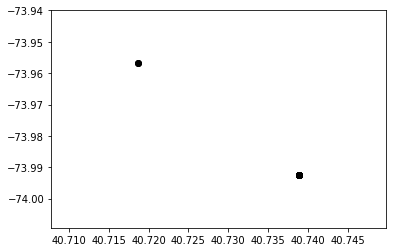

[(40.738933, -73.992373), (40.718639, -73.956914), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.718639, -73.956914), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373), (40.738933, -73.992373)]


In [46]:
user = "116"
x = []
y = []
print(len(user_checkin_history[user]))
for point in user_checkin_history[user]:
    x.append(point.latitude)
    y.append(point.longitude)
plt.scatter(x, y, color='black')
plt.show()
print(user_checkin_history[user])

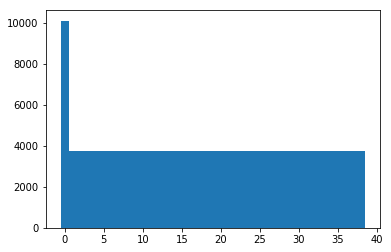

[10100, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715078, 3745.372951715338, 3745.372951715338]


In [47]:
POP = POPTICS(user_checkin_history[user], max(len(user_checkin_history[user])//20,3))
GL = POP.run()
#GL = POPTICS(user_checkin_history[user], 50 )
# for cluster in GL:
#     print(cluster.points)
POP.show()

0
1
2
3
4


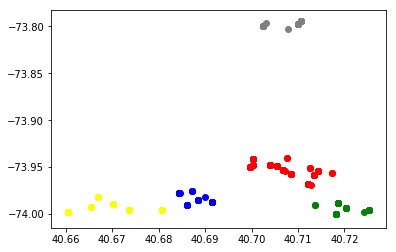

1148
583
565


In [44]:
account = 0
color = ["blue", "yellow", "green", "red", "gray"]
for i,cluster in enumerate(GL):
    x = []
    y = []
    account += len(cluster.points)
#     for p in cluster.points:
#         for pp in user_checkin_history[user]:
#             if p == pp:
#                 print(p, pp)
#                 account+=1
    for point in cluster.points:
        x.append(point.latitude)
        y.append(point.longitude)
    print(i)
    plt.scatter(x, y, color = color[i])
    #plt.axis([40.9649, 40.9665, -74.062, -74.064])
plt.show()
print(len(user_checkin_history[user]))
print(account)
print(len(user_checkin_history[user])- account)

In [48]:
user_clusters = defaultdict(list)
for user in users:
    print(user)
    POP = POPTICS(user_checkin_history[user], max(len(user_checkin_history[user])//20,3))
    user_clusters[user] = POP.run()
print("finish")

470
69
87
484
642
428
877
691
116
445
895
704
891
901
699
100
443
689
390
32
230
834
962
1032
525
318
1047
738
364
398
839
424
751
889
612
643
718
768
15
458
280
1016
281
276
80
673
337
916
639
752
713
1012
438
217
656
225
628
504
164
235
118
1054
881
706
143
1005
912
537
868
1055
907
303
793
784
734
540
816
623
294
615
173
16
7
592
636
865
621
272
591
976
562
783
319
468
874
107
667
557
725
880
288
335
769
403
573
346
968
539
184
144
71
688
65
885
267
820
516
176
528
30
246
515
710
145
498
894
313
120
798
1078
195
59
662
553
702
84
129
864
658
951
817
371
121
49
50
29
519
340
391
526
645
758
611
577
984
1025
354
373
902
571
440
987
185
559
279
529
131
207
943
179
444
586
510
1044
572
766
162
299
652
315
637
12
787
633
672
973
597
422
365
805
905
940
359
191
130
186
692
1009
806
1076
842
125
474
26
90
989
139
593
328
402
57
221
198
772
408
818
187
242
994
509
969
861
361
296
826
475
149
54
432
386
626
215
17
1013
848
188
434
14
854
985
1083
415
649
208
619
990
722
1042
480
362
495
1040

In [50]:
pickle.dump(user_clusters, open("user_clusters.pickle", 'wb'))
print("finish")

finish


In [56]:
# import numpy as np
#from scipy.spatial.distance import pdist, squarefrom
# def gaussian(x, mu, sig):
#     return 1/(np.sqrt(2*np.pi*np.power(sig,2)))*np.exp(-np.power((x-mu)/sig, 2)/2)
####################################demand_supply_ratio#########################################################
import math
import pickle
def gaussian_2d(x, y, mu_x, mu_y, sig):
    exp_value = -(np.power(x-mu_x, 2)+np.power(y-mu_y, 2))/(2*np.power(sig, 2))
    return 1/(np.sqrt(2*np.pi*np.power(sig,2)))*np.exp(exp_value)

user_clusters = pickle.load( open("user_clusters.pickle", 'rb') )
pattern_venue = pickle.load( open("pattern_point.pickle", 'rb') )

# user_clusterID = defaultdict(list)
# for user in user_checkin_history:
#     for p in user_checkin_history[user]:
#         for i,cluster in enumerate(user_clusters[user]):
#             if p in cluster.points:
#                 user_clusterID[user].append(i)
#                 break
#             else:
#                 user_clusterID[user].append(-1)

#print(user_clusterID)
#print(user_clusters)
# #demand level
# venues = [] #[(user1, user2 ...), (user1, user2, ...)]
# venue_user = [] #[venue1(user1, user2 ...), venue2(user1, user2 ...) ...]
# venue_pattern = [] #[pattern1(venue1, venue2, ...)]
venues = []
for user in user_clusters:
    for cluster in user_clusters[user]:
        for p in cluster.points:
            if p not in venues:
                venues.append(p)
            
venue_user = defaultdict(list)
for venue in venues:
#     print(venue)
    for user in user_clusters:
        for cluster in user_clusters[user]:
            if venue in cluster.points:
                venue_user[venues.index(venue)].append(user)
#venue_user format:{venue_index1:[user1, user2...],venue_index2:[user1, user2,...]}
#print(venue_user)

demand = defaultdict(float)
for venue in venue_user:
    demand[venue] = 0
    for user in venue_user[venue]:
        for cluster in user_clusters[user]:
            if venues[venue] in cluster.points:
                this_center = cluster.center
                this_radius = cluster.radius
                d = gaussian_2d(venues[venue].latitude, venues[venue].longitude, this_center.latitude, this_center.longitude, this_radius)
                print(this_radius)
    demand[venue] += d
#print(demand)

#demand format:{venue1: demand_value, venue2: demand_value,...}
#total demand
#read dictionary pattern_venue
# totaldemand = defaultdict(float)
# for pattern in pattern_venue:
#     totaldemand[pattern] = 0
#     for venue in venues:
#         if venue in pattern_venue[pattern]:
#             dt = demand[venues.index(venue)]
#             totaldemand[pattern] += dt


2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
104.73977545231216
425.31668890882156
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
188.9414053661983
2466.928659983256
2446.3489400272115
2466.928659983256
2466.928659983256
2466.928659983256
169.94547668659737
2466.928659983256
2466.928659983256
2466.928659983256
511.0007256709495
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
1725.3051551885635
2466.928659983256
2466.928659983256
2466.928659983256
2466.928659983256
5883.763846972475
2466.928659983256
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.763846972475
5883.

911.8924364623163
911.8924364623163
1546.1570738874582
911.8924364623163
911.8924364623163
3127.277846820293
2144.9715549602693
911.8924364623163
911.8924364623163
2144.9715549602693
911.8924364623163
911.8924364623163
334.3938793566487
911.8924364623163
911.8924364623163
911.8924364623163
911.8924364623163
595.8964731673075
911.8924364623163
911.8924364623163
1124.2176593698568
265.3288217558972
863.7453873930621
265.3288217558972
1110.0234800823364
265.3288217558972
115.44171969372285
863.7453873930621
265.3288217558972
265.3288217558972
265.3288217558972
929.7996835835779
265.3288217558972
60.40481049101303
265.3288217558972
1110.0234800823364
4.4120995651964
4.4120995651964
1151.8008346256445
20.323482732098356
21.271672512558645
21.271672512558645
21.271672512558645
89.4922666166171
89.4922666166171
65.95170093239584
89.4922666166171
89.4922666166171
89.4922666166171
89.4922666166171
89.4922666166171
89.4922666166171
14.434127721802415
14.434127721802415
45.116849500082374
45.1168

1546.1570738874582
378.0596961188311
327.9310651777853
327.9310651777853
1546.1570738874582
354.18312084112193
1100.3745955382547
354.18312084112193
354.18312084112193
354.18312084112193
18.454492570413592
926.5160330289506
1407.0258506958796
926.5160330289506
1407.0258506958796
44.35680970407752
354.18312084112193
354.18312084112193
770.243547615905
354.18312084112193
14.335223465149909
14.335223465149909
77.32944502149606
77.32944502149606
77.32944502149606
20.323482732098356
20.369928948220984
625.1581063728389
1676.4962221190442
1679.722593373115
20.369928948220984
38.996974424258234
38.996974424258234
38.996974424258234
38.996974424258234
276.2230637211306
276.2230637211306
276.2230637211306
276.2230637211306
276.2230637211306
48.39158803432175
276.2230637211306
770.243547615905
276.2230637211306
770.243547615905
111.56384084717378
28.654619353823744
28.654619353823744
28.654619353823744
28.654619353823744
28.654619353823744
9.298561235208009
87.48917560030957
275.48844264019476
9

369.3159866354877
369.3159866354877
369.3159866354877
369.3159866354877
281.6551962553761
281.6551962553761
816.0110644154905
816.0110644154905
816.0110644154905
816.0110644154905
615.4719898213965
816.0110644154905
615.4719898213965
615.4719898213965
615.4719898213965
1043.6925895677464
1043.6925895677464
1043.6925895677464
1043.6925895677464
1043.6925895677464
1043.6925895677464
1043.6925895677464
1043.6925895677464
1043.6925895677464
1043.6925895677464
715.0093285418391
715.0093285418391
715.0093285418391
1686.551057628288
919.7310349872486
919.7310349872486
919.7310349872486
919.7310349872486
919.7310349872486
919.7310349872486
193.95502110633683
919.7310349872486
11.677516229926445
11.677516229926445
39.71835601042512
40.98250011642244
115.29080881073314
12.128260190457684
40.98250011642244
115.29080881073314
12.128260190457684
12.128260190457684
11.732446812719711
90.77413787757517
11.732446812719711
11.732446812719711
7.207961067556136
7.207961067556136
11.842027093760604
11.842

290.998113554018
290.998113554018
290.998113554018
130.98242519834633
130.98242519834633
374.1386455594648
374.1386455594648
374.1386455594648
174.9620073076327
174.9620073076327
174.9620073076327
174.9620073076327
174.9620073076327
9.801044948298264
325.93448163730335
9.801044948298264
9.801044948298264
7.411951559654799
7.411951559654799
1725.3051551885635
1725.3051551885635
1725.3051551885635
1725.3051551885635
1725.3051551885635
1725.3051551885635
1725.3051551885635
1725.3051551885635
1725.3051551885635
1725.3051551885635
1725.3051551885635
1725.3051551885635
669.8909598212282
669.8909598212282
669.8909598212282
669.8909598212282
325.93448163730335
325.93448163730335
325.93448163730335
1158.3301686878983
1158.3301686878983
1158.3301686878983
1158.3301686878983
686.2398045377297
686.2398045377297
686.2398045377297
686.2398045377297
686.2398045377297
686.2398045377297
291.30204002076744
291.30204002076744
269.4234240707821
269.4234240707821
269.4234240707821
269.4234240707821
248.515

In [57]:
#total demand
#read dictionary pattern_venue
totaldemand = defaultdict(float)
for pattern in pattern_venue:
    totaldemand[pattern] = 0
    for venue in venues:
        if venue in pattern_venue[pattern]:
            dt = demand[venues.index(venue)]
            totaldemand[pattern] += dt


In [14]:
#print(totaldemand)

In [15]:
#defaultdict(<class 'float'>, {1: 6.1842149089561556, 3: 2.9455926757476565, 0: 14.192235860226486, 2: 15.270860094090434, 4: 16.39032580781028, 7: 12.442467252074932, 8: 16.894575702681514, 5: 4.945073418661651, 6: 4.507744411075705})

#output totaldemand[pattern]:
#0: 14.192235860226486
#1: 6.1842149089561556
#2: 15.270860094090434
#3: 2.9455926757476565
#4: 16.39032580781028
#5: 4.945073418661651
#6: 4.507744411075705
#7: 12.442467252074932
#8: 16.894575702681514

In [49]:
#supply level
#standard deviation for supply
def distance_venue(venue): 
    user_number = 0
    total_dist = 0
    for user in venue_user[venues.index(venue)]: 
        for cluster in user_clusters[user]:
            if venue in cluster.points:
                u_center = cluster.center
        dist = math.sqrt(math.pow(u_center.latitude - venue.latitude,2) + math.pow(u_center.longitude-venue.longitude,2))
        total_dist += dist
        user_number += 1
    average_dist = total_dist / user_number
    return average_dist

supply = defaultdict(float)
for venue in venues:
    #print(venue)
    supply[venues.index(venue)] = 0
    for user in venue_user[venues.index(venue)]:
        for cluster in user_clusters[user]:
            if venue in cluster.points:
                u_center = cluster.center
        s = gaussian_2d(u_center.latitude, u_center.longitude, venue.latitude, venue.longitude, distance_venue(venue))
        print(distance_venue(venue))
    supply[venues.index(venue)] += s

# #total supply
# totalsupply = defaultdict(float)
# for pattern in pattern_venue:
#     totalsupply[pattern] = 0
#     for venue in pattern_venue[pattern]:
#         st = supply[venue]
#         totalsupply[pattern] += st

       

0.013050287464987168
0.011662423263589624
0.01449555918161738
0.010654477776385634
0.012161470565410167
0.0036163601363257344
0.0036163601363257344
0.0036163601363257344
0.00945282727575724
0.007784328964641652
0.007757959094964933
0.013111849455610705
0.004802353551797106
0.004483743227265937
0.004483743227265937
0.009079897833099182
0.009079897833099182
0.010880684688331328
0.013535250389415424
0.001776720100020742
0.001776720100020742
0.017178525662632557
0.007775341136233896
0.005663797045595697
0.005663797045595697
0.007415940360332825
0.006194486267097126
0.010304781647230513
0.009817029031154076
0.009218401395973337
0.011720841337367914
0.011720841337367914
0.013695943036577937
0.016257329694842372
0.018059274249934833
0.0010666698836869699
0.0010666698836869699
0.002792750550485336
0.008239907819768242
0.004901070176562154
0.007677978190874644
0.011673580258890212
0.015011248893767615
0.015743762824089704
0.021376804515489234
0.02057678297985989
0.01726998432744303
0.0095087652

8.835377667078086e-05
0.00040565277890214574
0.00036407358475826305
0.0001787358430890603
0.00018478643742041327
0.0003335849446557739
0.00011654399254136134
0.00011654399254136134
0.0007541380783311205
0.00011042360191076275
0.0006268816526635559
0.0006268816526635559
0.0006268816526635559
0.0007306021898035357
0.007798003268838967
0.003286806904336245
0.006105392007007639
0.004918194962936721
0.014920651026354073
0.004436336977080079
0.004436336977080079
0.004436336977080079
0.0026639593811434905
0.002400132554153339
0.0037501443188990608
0.009114012902701365
0.009114012902701365
0.008278492764027232
0.008359195079568008
0.010059925736425427
0.006295312384125084
0.0066286176809456955
0.005980979153378513
0.007229097978215549
0.006476806921621755
0.0029246955722568692
0.004412630483449137
0.00430557752028504
0.003693932445648709
0.009311779472536669
0.00696648240827198
0.004839820747228069
0.013755975517821678
8.547428270159513e-05
1.6320714757486074e-05
5.672438132442238e-05
0.000277

0.0021093925164526683
0.002392036718046523
0.003644978964226697
0.002763921429598786
0.0036284470790416815
0.0036577095801692454
3.864868776050634e-05
0.00022886582584510356
0.0002030672776009697
0.00030309641417647376
0.029160700672508595
0.01876185025773957
0.01876185025773957
0.035119861691801646
0.039522167533474865
0.042309094782802995
0.028639625924787488
0.021667976692716334
0.020371138506946055
0.020816223519482417
0.021463983753795983
0.021335939235900964
0.010467403306696524
0.002426335824997415
0.0026911311209313177
0.004961321659427906
0.00825199390165735
0.010170969384681003
0.011802944579270057
0.013983573281552909
0.017470255222772884
0.020512217945966024
0.02223053886919847
0.02535931777434099
0.026719740023755375
0.027311297197787254
0.05233022677060251
0.01570182417425417
0.02116228642617181
0.02281307398087058
0.030853798990715275
0.03300281917865742
0.023887895446246893
0.0021168905492560774
0.0021168905492560774
0.0021168905492560774
0.0021168905492560774
0.0014735

8.762081345018433e-05
7.142160006304306e-05
3.060925716738241e-05
0.0024935591633848788
0.0011713210064549144
0.005968006784889478
0.005968006784889478
0.0013170956186210716
0.006266814432707619
0.006266814432707619
0.0031791554794775214
0.0036153731627743225
0.004022034348858509
0.004022034348858509
0.004022034348858509
0.005462971562555298
0.0034085950535366867
0.0034085950535366867
0.004236197108634022
0.004236197108634022
0.004236197108634022
0.0006872530371271615
0.0009865761717799168
0.0009619351446197238
0.000662848287263779
0.000910811456704549
0.0009745243080292569
0.002425939983671061
0.0013778033323001081
0.0013778033323001081
0.0013778033323001081
0.0035982558872489478
0.0035982558872489478
0.003333824733343098
0.004159133146085101
0.004159133146085101
0.004159133146085101
0.0022998907821917686
0.002888072371054812
0.002888072371054812
0.001340063369015757
0.0006616083100389529
0.0008830341323334626
0.001206390671257581
0.0020148137692298125
0.0020148137692298125
0.00149348

0.0002618252045183353
5.4702967598746744e-05
0.0021664540604698387
0.0019413761944188088
0.0028564897390773525
0.0028542083612769368
0.0011059932008755954
0.0026508082178320533
0.0026508082178320533
0.0027394773984526044
0.0041039233792763965
0.004226081659727627
0.0010196453777426605
0.0014514681792020658
0.0007514657766400559
0.001152019424304145
4.2262573823423575e-05
4.9087615234217466e-05
9.182045561282892e-05
0.00012469556737565183
0.000999349695724471
0.0005874670442254014
0.0001699335027899637
0.0002307611219665073
0.0002936750086295484
4.1953572671468185e-05
0.000603931470957444
0.0006677632041785704
0.0002641098928197202
0.0002641098928197202
0.0009391995856521335
0.0009391995856521335
0.005332338625029572
0.0030945884910982785
0.0030945884910982785
0.003270832228993481
0.003270832228993481
0.002904990744863352
0.002731528772267791
0.003422600417653001
0.003422600417653001
0.008781177785181097
0.0006386160453964253
0.010927878079063758
0.014827125917370152
0.00985268054448236

0.0006328869503623741
0.00016026883463695054
0.0032470195969774673
0.0032470195969774673
0.00020525529204969202
0.0006793008747845155
4.746582830046116e-05
0.0009165631380338195
5.621024363204926e-05
0.00012961299281439098
0.000143269446879843
0.00026372511035195845
0.000311675130436975
0.0008668762022108522
0.0008668762022108522
0.003834909090042142
0.003834909090042142
0.003834909090042142
0.003834909090042142
0.002685269330810563
0.0009021225979559674
0.0009021225979559674
0.0020193006420728427
0.005329832677974391
0.0034442106953426047
0.0034442106953426047
0.006088721034484847
0.0013300980656456918
0.001989184304879027
0.001989184304879027
0.001989184304879027
0.003285070497389189
0.0027917652642847563
0.00079252003886093
0.0011447352138622947
0.0034373979395364196
0.0034373979395364196
0.0036664534037266243
0.0036664534037266243
0.0036664534037266243
0.0036664534037266243
0.0039465538390104134
0.0039465538390104134
5.403416663000447e-05
0.00027017083313836355
0.000677521288706919

0.0006347897128026774
0.0004452036333928868
0.0004501711494258311
0.0004616246667367366
0.00030899458461566376
0.0005002591446382743
0.0006798490373159992
0.0002311895911186737
0.00010799656960008273
0.0004629168560445807
0.0006933184187785859
0.0006933184187785859
0.0026744610922508003
0.0026744610922508003
5.600651733115764e-05
0.003296250903300347
0.003296250903300347
0.003296250903300347
0.00041560351254307315
8.312070250007817e-05
0.0001258596943803365
0.00013011863229021352
0.00020144133644890827
0.0003102469948674431
6.527753891248284e-05
0.00012774852273150756
0.00019018054965888817
0.00011638264211575084
2.3276528434371465e-05
0.004460378158703351
0.004460378158703351
0.004460378158703351
1.3884640003446376e-05
0.00883516122906794
0.00883516122906794
0.00883516122906794
0.00602692355839102
0.00602692355839102
0.00602692355839102
0.0035617850191465915
0.003276089189614044
0.002116089392630988
0.0028867155460508705
0.0028867155460508705
0.0008972613421859454
0.003351482137242146

0.003052453080494966
0.004133385094020946
0.0030029738070216144
0.0030029738070216144
0.01034472568003379
0.012813369568035022
0.013715662091347381
0.014863706608275393
0.016059656667216888
0.0073048948135504485
0.01190584820682652
0.0021973750898341814
0.001962158292791774
0.0021967151235967766
0.0031691663884927937
0.003217480592733599
0.003573530641047445
0.008127236618507583
2.535340918846716e-05
3.0424091008643545e-05
0.0007436909093568601
3.745185819322325e-05
0.0005212130207381702
0.0020266804466589367
0.0005303176503860151
0.00247788631108761
0.003731683339203344
0.0015958230344086586
0.003999704670499056
6.265479946594437e-05
3.169764686828979e-05
6.274948246509212e-05
0.0007280559638280905
0.0007280559638280905
0.0001426655339038441
0.0002408040445545111
0.004030563008970313
0.0026904860814051038
0.004727890213954567
0.005713545000998547
0.004462839630746196
0.0008722573614858567
0.003088644655007422
0.0038149154179866846
0.005736447857599894
0.003526368781789634
0.0035263687

0.00035466313394840203
0.0009236777850001751
0.0010126142465227527
0.0005828457739246807
0.0004619479779718146
0.0001880531870214008
0.0002264348727680141
1.4853708846039127e-05
5.921215893101311e-05
0.0005210857525057813
0.0011569789154981646
0.00035142777681292385
0.00040414533619230296
0.0007220099722607018
0.0016387465261785753
0.0016390220535869163
0.0031625635433786387
0.002211013487317644
0.004069899966365215
0.0077858851678494646
0.003264586369930049
0.003264586369930049
0.0009761280166290551
0.00043960126966538884
0.0035202006254394344
0.00390247595436441
0.0027523953323329658
0.0022045643390444973
0.007485311027367503
0.002320947711256094
0.003655809931911374
0.007077134738390665
0.007077134738390665
0.0009245263927265456
0.0016367609806917582
0.001956458654781464
0.003252467347342233
0.0024051420089709055
0.00403349772960203
0.0032743696445876325
0.007336293930325381
0.007542612128457148
0.006340358627444833
0.00819517419250621
0.009849879442047342
0.004272329341831138
0.002

0.012609657631426806
0.015117024766906637
0.010695917568134268
0.01070358083187665
0.00944686227804053
0.015545915215721936
0.009545254579015044
0.0096353450166774
0.008805008045632817
0.012633940409919473
0.012879619195730352
0.01319036154628805
0.012590359013241867
0.006491982605125325
0.006491982605125325
0.010308083834843343
0.009051271727253665
0.010918174409522358
0.011770862845387468
0.004355085361530762
0.004449443934797284
0.004405906350431098
0.004405906350431098
0.004405906350431098
0.004405906350431098
0.0019163750823452208
0.0019163750823452208
0.007430807798595485
0.004528869749869559
0.007340355602071977
0.007340355602071977
0.005675323867881619
0.005197910082234131
0.005197910082234131
0.00026591931208910357
0.0002524716349276325
0.00016653716130197915
0.00013901030120768598
0.00021617512244139937
0.00047957822219681746
0.00017697756362893563
3.539551270872822e-05
3.235381943511584e-05
2.156921296858627e-05
9.228994330834469e-06
2.30724859389698e-06
0.000317744468515455

0.00013874957399023826
0.00037317785135264694
4.3026123059615196e-05
0.0002448702464956264
0.00035460099183019675
0.00010838135516202771
0.00034033676778603213
0.0004452425153222889
0.00018813758377509812
2.4824381824026367e-05
5.5868530856554e-05
0.0008295758181616425
0.00031423396950282386
9.251827350300571e-05
0.0003297795553553978
0.00039352439639742066
0.0002639746995933363
0.0003005403148247599
7.371671716789055e-05
0.00012926883772884258
0.0002078004402634249
2.6583112113291188e-05
5.9812002243479304e-05
0.00035671440381993805
0.0035148157762094853
0.0035148157762094853
0.00011506408648131215
0.0001614005020838431
2.904647902383085e-05
0.00017576484953992766
0.00019883061575744383
3.0014831415656954e-05
0.010411136811991373
0.01060148314009364
0.009728596235541056
0.002561653443181084
0.005911020363251574
0.006335926009053163
0.008028327298164375
0.010057076834897942
0.011352785251495922
0.0013308260318824479
0.0009107378886522543
0.0011036249518629523
0.0013556132557194418
0.00

0.0009511371240505823
0.0016675308567149552
1.8245658563301744e-05
3.649131709798004e-05
0.0005466191158734971
6.36866119509984e-05
0.0020022910111069186
0.0004516415475219787
0.0008125086769286886
0.0008068269302479248
0.0013813846207350606
0.0011279626283347461
0.0010268261902373675
0.0008376338051161962
0.0013468357029876865
0.0016182092777662295
0.002270672817168304
0.0001201257729762364
6.471807569215342e-05
0.00019408193018535387
0.00029771732179611766
2.172847434110821e-05
0.0001738277947305078
0.00043967203381115434
0.0003219891135333669
0.0003727295988039412
0.00028550019377594066
0.00014873793271223432
0.0001647923794316193
0.001315584814533772
0.0004603520389724041
7.297607105207817e-06
1.4595214178678279e-06
0.005802655019874471
0.0015774566520887188
0.002760970491236353
0.0033104283815431723
0.010970025986470473
0.0034925880605451054
0.008681392251674894
0.0016564195122685623
0.0028065427541819
0.0029107858847094857
0.006711962138830219
0.006597215891132092
0.0100816445576

0.00451957640718558
0.006299850716032232
0.007426730993005248
0.0005884469029601752
0.0005288719471365156
0.0002015043056805582
0.0015769722049825585
0.0002679276254497413
0.0001283082202224295
0.0003862462228778402
0.0004216604686974824
8.750570754748513e-05
0.0002879607380163811
0.0005737934759642145
0.000129790794912623
0.000129790794912623
0.00016349532145784506
0.0003114068240814145
0.000360189567174933
0.000855467715541975
0.0001358325818709404
0.0008005713497673882
0.001127416126105795
0.000699508475989591
0.00041316220313193154
0.001651746579638787
0.0006744306607813778
0.0003742328838205699
0.0006006986467573262
5.3203181349228115e-06
6.384381777812284e-06
3.171937473465323e-05
0.00022203562313871276
0.0001269701553587033
0.0001523641863871532
3.5874494995403914e-05
2.048161658723039e-05
0.0007572494930138298
0.0004446948768261705
0.0002751844312540932
0.00014917576168759349
0.0005728986938788519
0.0010001502450394737
0.00017600737905164725
8.478794950331088e-05
0.000284743795

In [46]:
print(supply)

defaultdict(<class 'float'>, {0: 0.00030569616297864273, 1: 0.00034207494563071923, 2: 0.0002752168960045407, 3: 0.00037443625934036203, 4: 0.0003280378620626382, 5: 0.0011031597113041877, 6: 0.0004220348777604501, 7: 0.0005124941175964943, 8: 0.0005142361225395052, 9: 0.0003042608761884265, 10: 0.0008307224282397865, 11: 0.0008897527359984001, 12: 0.0004393686886074804, 13: 0.0003666518163230293, 14: 0.00029474318457637006, 15: 0.0022453862056844615, 16: 0.00023223313118731805, 17: 0.0005130865300846714, 18: 0.0007043724857742559, 19: 0.0005379523849940739, 20: 0.0006440280326401286, 21: 0.0003871428760343547, 22: 0.0004063778146274734, 23: 0.0004327673131653244, 24: 0.0003403700032221162, 25: 0.0002912850026581047, 26: 0.0002453922555978242, 27: 0.00022090714989996075, 28: 0.003740072598680035, 29: 0.0014284923525022873, 30: 0.0004841586691350952, 31: 0.0008139901409477936, 32: 0.000519592880396082, 33: 0.00034174800835216283, 34: 0.00026576221819033245, 35: 0.00025339703401213565, 3

In [50]:
#total supply
totalsupply = defaultdict(float)
for pattern in pattern_venue:
    totalsupply[pattern] = 0
    for venue in venues:
        if venue in pattern_venue[pattern]:
            st = supply[venues.index(venue)]
            totalsupply[pattern] += st


In [51]:
print(totalsupply)

defaultdict(<class 'float'>, {1: 864201.5378015477, 3: 536540.2556263505, 0: 2053953.3441792252, 2: 2131434.695553412, 4: 2621565.861094654, 7: 1895039.8880813827, 8: 2427104.22632276, 5: 1011083.2921233224, 6: 701162.9356972469})


In [45]:
#output totalsupply[pattern]:
#0: 2053953.3441792252
#1: 864201.5378015477
#2: 2131434.695553412
#3: 536540.2556263505
#4: 2621565.861094654
#5: 1011083.2921233224
#6: 701162.9356972469
#7: 1895039.8880813827
#8: 2427104.22632276

In [60]:
#demand_supply_ratio
dsr = []
for i in range(9):
    print(totaldemand[i])
    print(totalsupply[i])
    dsr.append((totaldemand[i]/totalsupply[i])*100000)
print(dsr)

14.192235860226486
2053953.3441792252
6.1842149089561556
864201.5378015477
15.270860094090434
2131434.695553412
2.9455926757476565
536540.2556263505
16.39032580781028
2621565.861094654
4.945073418661651
1011083.2921233224
4.507744411075705
701162.9356972469
12.442467252074932
1895039.8880813827
16.894575702681514
2427104.22632276
[0.6909716766666775, 0.7155986929493613, 0.7164592059024103, 0.5489975160035304, 0.6252112926495915, 0.4890866516325045, 0.6428954215318208, 0.6565807574991048, 0.6960795304731527]


In [20]:
# #user_clusters.pickle
# import pickle
# dd = pickle.load( open("user_clusters.pickle", 'rb') )
# print(dd)

In [20]:
# import pickle
# pattern_point = pickle.load(open("pattern_point.pickle", "rb"))
# #format: {pattern0: [p1, p2, ...]} pattern 0 - 8
# #print(pattern_point[0][0])